In [1]:
from bs4 import BeautifulSoup
import requests
from functools import lru_cache
import re
import datetime
import time
import pandas as pd
import plotly.express as px
import seaborn as sns

In [8]:
pagelineplotrequests.get('https://www.saq.com/en/12073995')

In [9]:
soup = BeautifulSoup(page.content)


In [10]:
soup.title

<title>19 Crimes Shiraz/Grenache/Mataro | Product page | SAQ.COM</title>

In [19]:
soup.find_all('stock_label_container')

[]

In [177]:
HEADER = {'Host': 'www.saq.com',
'Referer': 'https://www.saq.com/en/12073995',
'Host': 'www.saq.com',
'Accept': 'application/json',
'X-Requested-With': 'XMLHttpRequest'}

MAX_STORES = 100
def retrieve_stock(product_id):
    query = f"https://www.saq.com/en/saq_inventory/product/internal/id/{product_id}/?_=1585498276470"
    response = requests.get(query, headers=HEADER)
    return response.json()

def _parse_stock_json_for_store(store_json):
    output_list = []
    for store in store_json['list']:
        output_list.append({'id': store['identifier'],
                     'name': store['name'],
                     'postcode': store['postcode'],
                     'qty': store['qty']})
    return output_list
    
def retrieve_per_store_stock(product_id, max_stores=MAX_STORES):
    # For per stock we need to use this other bloody ID
    alt_product_id = fetch_alterantive_product_id(product_id)
    
    # It's paged, and we want to retrieve multiple sets of 10 stores
    output = []
    for loaded in range(0, max_stores, 10):
        query=f'https://www.saq.com/en/store/locator/ajaxlist/context/product/id/{alt_product_id}?loaded={loaded}&_=1585504408733'
        response = requests.get(query, headers=HEADER)
        output.extend(_parse_stock_json_for_store(response.json()))
    return output


In [262]:
retrieve_stock(305444)

{'stock': 156, 'source': 1}

In [180]:
# some bottles don't seem to be queryable under their product code, instead we can fetch it from the pricebox

In [55]:
page = requests.get('https://www.saq.com/en/14376324')
soup = BeautifulSoup(page.content)

In [72]:
ret = soup.find("div", {'data-product-id':'*'})

In [73]:
ret

In [77]:
ret = soup.find('div', {'class':'price-box'})

In [86]:
product_id = int(ret.attrs['data-product-id'])

In [94]:
@lru_cache(maxsize=512)
def fetch_alternative_product_id(original_product_id):
    page = requests.get(f'https://www.saq.com/en/{original_product_id}')
    soup = BeautifulSoup(page.content)
    ret = soup.find('div', {'class':'price-box'})
    product_id = int(ret.attrs['data-product-id'])
    return product_id

In [95]:
original = 14207918
alternative=fetch_alternative_product_id(original)

In [96]:
retrieve_stock(alternative)

{'stock': 8, 'source': 1}

In [43]:
def get_stock_from_webpage(url):
    product_regex = '1{1}\d{7}'

    # Parse product ID out of webpage
    product_id = re.search(product_regex, url).group(0)
    
    product_stock = get_stock_from_id(product_id)

    return product_stock
        
    
def get_stock_from_id(product_id):
    per_store = retrieve_per_store_stock(product_id)
    stock_json = retrieve_stock(product_id)

    if stock_json['source'] == 2:
        # Stored under alternative product id
        alternative_product_id = fetch_alternative_product_id(product_id)
        stock_json = retrieve_stock(alternative_product_id)    

    return stock_json
            
def get_soup(url):
    return BeautifulSoup(requests.get(url).content)
    

In [101]:
get_stock_from_webpage('https://www.saq.com/fr/12073995')

{'stock': 627, 'source': 1}

In [102]:
get_stock_from_webpage('https://www.saq.com/fr/14376324')

{'stock': 156, 'source': 1}

In [103]:
# Get all the red wines
base_url = 'https://www.saq.com/en/products/wine/red-wine?product_list_limit=96'

In [106]:
red_wine_soup = get_soup(base_url)

In [112]:
list_items = red_wine_soup.find('ol', {'class': 'product-items'})


In [118]:
children = list_items.findChildren('li', {'class': 'item product product-item'})

In [120]:
len(children)

96

In [123]:
children[0].find('div', {'product'}).attrs['data-product-id']

'207143'

In [124]:
def parse_product_list(product_list_url):

    wine_soup = get_soup(product_list_url)
    list_items = red_wine_soup.find('ol', {'class': 'product-items'})
    children = list_items.findChildren('li', {'class': 'item product product-item'})
    product_ids = []
    for c in children:
        product_names.append(c.find, 'div', {'class':'product-item-content-container'})
        product_ids.append(c.find('div', {'product'}).attrs['data-product-id'])
    return product_ids

In [125]:
product_ids = parse_product_list(base_url)

In [127]:
product_urls = [f"https://www.saq.com/fr/{product_id}" for id in product_ids]

In [131]:
product_stock = [get_stock_from_id(id) for id in product_ids]

In [282]:
red_wine_soup = get_soup(base_url)

In [283]:
list_items = red_wine_soup.find('ol', {'class': 'product-items'})
children = list_items.findChildren('li', {'class': 'item product product-item'})

In [286]:
c = children[0]

In [291]:
c.find('span', {'class': 'show-for-sr'}).text

'\n                                19 Crimes Shiraz/Grenache/Mataro                                                                                                                                        750                                    ml                                                            '

## In store availability

A sanity check: pick a single wine, get its availablity across 100 stores every minute for 10 minutes - do they change

In [269]:
a = {'a': 5}
b = {'b': 10}
a.update(b)

In [270]:
a


{'a': 5, 'b': 10}

In [182]:
product_id = 12073995

In [184]:
timesteps = 10

In [275]:
red_wine_ids = parse_product_list('https://www.saq.com/en/products/wine/red-wine?product_list_limit=96')

In [276]:
output=[]
web_output = []
for i in range(timesteps):
    print(i)
    now = datetime.datetime.now()
    time_dict = {'time':now}
#     output.append([s.update(time_dict) for s in retrieve_per_store_stock(product_id)])
    
    for id in red_wine_ids:
        data = get_stock_from_id(product_id)
        data.update(time_dict)
        data.update({'product_id': id})
        
    web_output.append(data)
    time.sleep(10)

0
1
2
3
4
5
6
7
8
9


In [278]:
web_output

[{'stock': 613,
  'source': 1,
  'time': datetime.datetime(2020, 3, 29, 15, 2, 7, 937062),
  'product_id': '286490'},
 {'stock': 613,
  'source': 1,
  'time': datetime.datetime(2020, 3, 29, 15, 3, 44, 790203),
  'product_id': '286490'},
 {'stock': 613,
  'source': 1,
  'time': datetime.datetime(2020, 3, 29, 15, 5, 18, 626491),
  'product_id': '286490'},
 {'stock': 613,
  'source': 1,
  'time': datetime.datetime(2020, 3, 29, 15, 6, 53, 906096),
  'product_id': '286490'},
 {'stock': 613,
  'source': 1,
  'time': datetime.datetime(2020, 3, 29, 15, 8, 34, 813680),
  'product_id': '286490'},
 {'stock': 613,
  'source': 1,
  'time': datetime.datetime(2020, 3, 29, 15, 10, 13, 823809),
  'product_id': '286490'},
 {'stock': 613,
  'source': 1,
  'time': datetime.datetime(2020, 3, 29, 15, 11, 46, 665644),
  'product_id': '286490'},
 {'stock': 613,
  'source': 1,
  'time': datetime.datetime(2020, 3, 29, 15, 13, 19, 199986),
  'product_id': '286490'},
 {'stock': 613,
  'source': 1,
  'time': datet

In [208]:
# We really just want times x stores x quantity

In [215]:
def remap_output(input):
    out = []
    for time, item in input.items():
        for store in item:
            out.append(dict(time=time, store=store['name'], qty=store['qty']))
    return out

In [217]:
flat_format = remap_output(output)

In [222]:
df = pd.DataFrame(flat_format)

In [237]:
df['qty'] = df['qty'].astype(int)

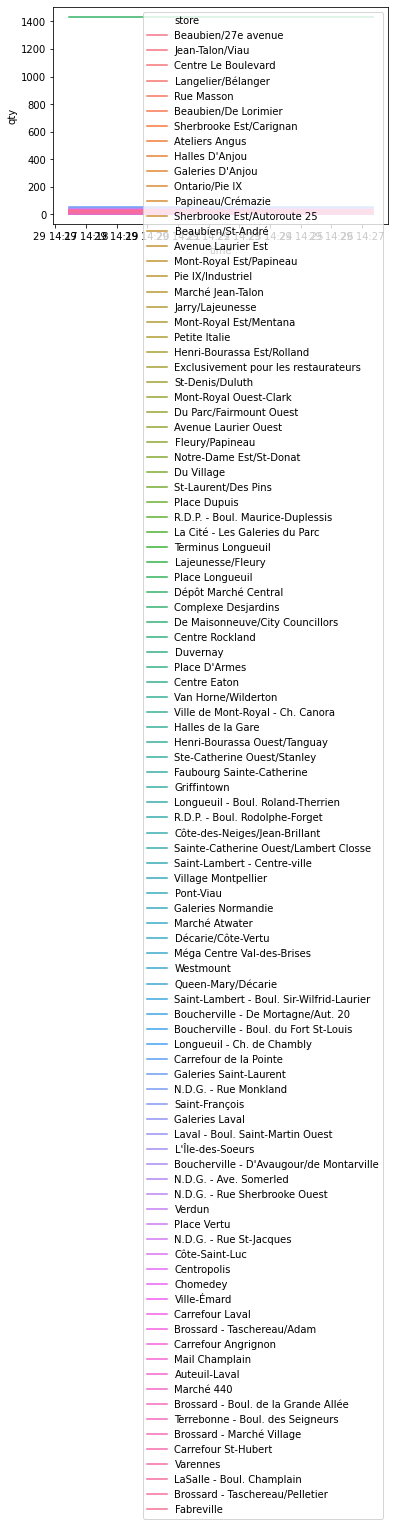

In [238]:
sns.lineplot(data=df, x='time', y='qty', hue='store')

In [239]:
df.qty.sum()

32100

In [240]:
df.qty

0      17
1      11
2      11
3      21
4      12
       ..
995    22
996    10
997    21
998    28
999    24
Name: qty, Length: 1000, dtype: int64

In [253]:
df.groupby('time').sum()

,qty
time,
2020-03-29 14:17:26.170428,3210
2020-03-29 14:18:32.282484,3210
2020-03-29 14:19:37.657980,3210
2020-03-29 14:20:43.300203,3210
2020-03-29 14:21:50.370151,3210
2020-03-29 14:22:56.936546,3210
2020-03-29 14:24:03.395453,3210
2020-03-29 14:25:08.675630,3210
2020-03-29 14:26:15.086523,3210


In [254]:
latest = retrieve_per_store_stock(product_id)

In [258]:
total = sum([int(l['qty']) for l in latest])

In [259]:
total

3210

In [18]:
html = requests.get('https://www.saq.com/en/products/wine?availability=Online')

In [19]:
wine_soup = BeautifulSoup(html.content)

In [24]:
wine_soup.find_all('span', {'class': 'toolbar-number'})[-1].contents

['1176']

In [4]:
list_items = wine_soup.find('ol', {'class': 'product-items'})
children = list_items.findChildren('li', {'class': 'item product product-item'})
product_ids = []
product_names = []
product_images = []
c = children[0]

In [25]:
span = c.find('strong', {'class': 'product-item-identity-format'}).findChildren('span')[0].contents[0].strip()

In [26]:
span

'Red wine'

In [36]:
span = c.find('strong', {'class': 'product-item-identity-format'}).findChildren('span')

In [37]:
span

[<span>
                                             Red wine                                                                                                    <span class="divider"> | </span>
                                                     750                                                    ml                                                                                                                                                                                        <span class="divider"> | </span>
                                                 Spain                                                                                    </span>,
 <span class="divider"> | </span>,
 <span class="divider"> | </span>]

In [41]:
span[0].contents[-1].strip()

'Spain'

# Wikipedia data for cases

In [46]:
wiki_soup = get_soup('https://en.wikipedia.org/wiki/Template:2019–20_coronavirus_pandemic_data/Canada/Quebec_medical_cases_chart')

In [49]:
case_table = wiki_soup.find('table')

In [51]:
all_rows = case_table.findAll('tr')

In [54]:
# First row 
all_rows[2]

<tr>
<td colspan="2" style="padding-left:0.4em; padding-right:0.4em; text-align:center">2020-02-28</td>
<td style="border-left:1px solid silver; border-right:1px solid silver">
<div style="background:Black; float:left; overflow:hidden; width:0px" title="0">​</div>
<div style="background:SkyBlue; float:left; overflow:hidden; width:0px" title="0">​</div>
<div style="background:Tomato; float:left; overflow:hidden; width:0.058555627846454px" title="1">​</div>
<div style="background:Gold; float:left; overflow:hidden; width:0px" title="0">​</div>
<div style="background:OrangeRed; float:left; overflow:hidden; width:0px" title="0">​</div>
</td>
<td style="padding-left:0.4em; padding-right:0.4em; text-align:center"><span class="nowrap"><span style="width:3.5em; padding:0 0.3em 0 0; text-align:right; display:inline-block">1</span><span style="width:4.55em; text-align:left; display:inline-block">(n.a.)</span>
</span></td>
<td style="padding-left:0.4em; padding-right:0.4em; text-align:center"><spa

In [71]:
date = all_rows[2].findAll('td')[0].contents[0]

In [72]:
date

'2020-02-28'

In [81]:
for cols in all_rows[2].findAll('td'):
    print(cols.contents)

['2020-02-28']
['\n', <div style="background:Black; float:left; overflow:hidden; width:0px" title="0">​</div>, '\n', <div style="background:SkyBlue; float:left; overflow:hidden; width:0px" title="0">​</div>, '\n', <div style="background:Tomato; float:left; overflow:hidden; width:0.058555627846454px" title="1">​</div>, '\n', <div style="background:Gold; float:left; overflow:hidden; width:0px" title="0">​</div>, '\n', <div style="background:OrangeRed; float:left; overflow:hidden; width:0px" title="0">​</div>, '\n']
[<span class="nowrap"><span style="width:3.5em; padding:0 0.3em 0 0; text-align:right; display:inline-block">1</span><span style="width:4.55em; text-align:left; display:inline-block">(n.a.)</span>
</span>]
[<span style="width:4.55em; padding:0 0.3em 0 0; text-align:right; display:inline-block"></span>, <span style="width:3.5em; text-align:left; display:inline-block"></span>]


In [86]:
case = all_rows[2].findAll('td')[2].contents[0].find('span').contents[0]

In [100]:
all_rows[20].findAll('td')[3].contents[0].contents[0]

'4'

In [103]:
for i, row in enumerate(all_rows[2:31]):
    date = row.findAll('td')[0].contents[0]
    cases = row.findAll('td')[2].contents[0].find('span').contents[0]
    try:
        deaths = row.findAll('td')[3].contents[0].contents[0]
    except:
        deaths = 0
    print(date, cases, deaths)

2020-02-28 1 0
2020-03-5 2 0
2020-03-6 3 0
2020-03-7 3 0
2020-03-8 4 0
2020-03-9 4 0
2020-03-10 7 0
2020-03-11 8 0
2020-03-12 17 0
2020-03-13 17 0
2020-03-14 24 0
2020-03-15 39 0
2020-03-16 50 0
2020-03-17 74 0
2020-03-18 94 1
2020-03-19 121 1
2020-03-20 139 1
2020-03-21 181 4
2020-03-22 219 4
2020-03-23 628* 4
2020-03-24 1040 4
2020-03-25 1339 6
2020-03-26 1629 8
2020-03-27 2021 18
2020-03-28 2498 22
2020-03-29 2840 22
2020-03-30 3430 25
2020-03-31 4162 31
2020-04-1 4611 33


# Use downloaded .xlsx instead

In [104]:
download_url = 'https://docs.google.com/spreadsheets/d/1D6okqtBS3S2NRC7GFVHzaZ67DuTw7LX49-fqSLwJyeo/export?format=xlsx'

In [105]:
path_to_download = '/Users/archydeberker/Desktop/code/saq/scripts/canada_case_data_20200401-192009.csv'
!pip install xlrd

In [117]:
cases_df = pd.read_excel(path_to_download, header=3)
deaths_df = pd.read_excel(path_to_download, header=3, sheet_name=1)
recovered_df = pd.read_excel(path_to_download, header=3, sheet_name=2)

In [118]:
def filter_for_quebec(df):
    return df.loc[df['province']=='Quebec']

In [120]:
cases_df= filter_for_quebec(cases_df)
deaths_df = filter_for_quebec(deaths_df)
recovered_df = filter_for_quebec(recovered_df)

In [122]:
recovered_df

,date_recovered,province,cumulative_recovered,Unnamed: 3,Unnamed: 4,province_source,source
392,2020-03-31,Quebec,84.0,NaN,NaN,NaN,NaN
393,2020-03-30,Quebec,84.0,NaN,NaN,NaN,NaN
394,2020-03-29,Quebec,84.0,NaN,NaN,NaN,NaN
395,2020-03-28,Quebec,29.0,NaN,NaN,NaN,NaN
396,2020-03-27,Quebec,29.0,NaN,NaN,NaN,NaN
397,2020-03-26,Quebec,1.0,NaN,NaN,NaN,NaN
398,2020-03-25,Quebec,1.0,NaN,NaN,NaN,NaN
399,2020-03-24,Quebec,1.0,NaN,NaN,NaN,NaN
400,2020-03-23,Quebec,1.0,NaN,NaN,NaN,NaN
401,2020-03-22,Quebec,1.0,NaN,NaN,NaN,NaN


In [123]:
deaths_df

,death_id,province_death_id,case_id,age,sex,health_region,province,country,date_death_report,death_source,additional_info,additional_source
8,9,1,NaN,80-89,Female,Lanaudière,Quebec,Canada,2020-03-18,NaN,1.0,https://montreal.ctvnews.ca/covid-19-quebec-ha...
14,15,2,NaN,Not Reported,Not Reported,Lanaudière,Quebec,Canada,2020-03-21,NaN,1.0,https://montreal.ctvnews.ca/quebec-premier-ann...
15,16,3,NaN,Not Reported,Not Reported,Lanaudière,Quebec,Canada,2020-03-21,NaN,1.0,https://montreal.ctvnews.ca/quebec-premier-ann...
16,17,4,NaN,Not Reported,Not Reported,Lanaudière,Quebec,Canada,2020-03-21,NaN,1.0,https://montreal.ctvnews.ca/quebec-premier-ann...
28,29,5,NaN,Not Reported,Not Reported,Not Reported,Quebec,Canada,2020-03-25,NaN,NaN,https://www.quebec.ca/en/health/health-issues/...
29,30,6,NaN,Not Reported,Not Reported,Not Reported,Quebec,Canada,2020-03-25,NaN,NaN,https://www.quebec.ca/en/health/health-issues/...
37,38,7,NaN,Not Reported,Not Reported,Montréal,Quebec,Canada,2020-03-26,NaN,NaN,https://www.cbc.ca/news/canada/montreal/covid1...
38,39,8,NaN,90-99,Male,Laurentides,Quebec,Canada,2020-03-26,NaN,NaN,https://montreal.ctvnews.ca/confirmed-cases-of...
43,44,9,NaN,Not Reported,Not Reported,Not Reported,Quebec,Canada,2020-03-27,NaN,NaN,https://montreal.ctvnews.ca/18-people-have-now...
44,45,10,NaN,Not Reported,Not Reported,Not Reported,Quebec,Canada,2020-03-27,NaN,NaN,https://montreal.ctvnews.ca/18-people-have-now...


In [124]:
cases_df

,case_id,provincial_case_id,age,sex,health_region,province,country,date_report,report_week,travel_yn,travel_history_country,locally_acquired,case_source,additional_info,additional_source
13,14,1,40-49,Female,Montréal,Quebec,Canada,2020-02-27,2020-02-23,1,Iran,NaN,(1) https://www.cbc.ca/news/canada/montreal/co...,Travel from Iran via Qatar,https://www.cbc.ca/news/canada/montreal/covid-...
34,35,2,70-79,Male,Laurentides,Quebec,Canada,2020-03-05,2020-03-01,1,India,NaN,(1) https://www.msss.gouv.qc.ca/ministere/sall...,NaN,NaN
50,51,3,Not Reported,Not Reported,Montérégie,Quebec,Canada,2020-03-06,2020-03-01,1,France,NaN,https://www.msss.gouv.qc.ca/ministere/salle-de...,someone they had been in contact with in Franc...,https://www.cbc.ca/news/canada/montreal/3rd-co...
61,62,4,Not Reported,Female,Montérégie,Quebec,Canada,2020-03-08,2020-03-08,1,Cruise (Mexico),NaN,https://www.msss.gouv.qc.ca/ministere/salle-de...,NaN,NaN
78,79,5,Not Reported,Male,Montréal,Quebec,Canada,2020-03-09,2020-03-08,1,"United States, Ireland, United Kingdom",NaN,https://www.msss.gouv.qc.ca/ministere/salle-de...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8455,8456,4158,Not Reported,Not Reported,Saguenay,Quebec,Canada,2020-03-31,2020-03-29,Not Reported,NaN,NaN,https://www.quebec.ca/sante/problemes-de-sante...,NaN,NaN
8456,8457,4159,Not Reported,Not Reported,Saguenay,Quebec,Canada,2020-03-31,2020-03-29,Not Reported,NaN,NaN,https://www.quebec.ca/sante/problemes-de-sante...,NaN,NaN
8457,8458,4160,Not Reported,Not Reported,Saguenay,Quebec,Canada,2020-03-31,2020-03-29,Not Reported,NaN,NaN,https://www.quebec.ca/sante/problemes-de-sante...,NaN,NaN
8458,8459,4161,Not Reported,Not Reported,Saguenay,Quebec,Canada,2020-03-31,2020-03-29,Not Reported,NaN,NaN,https://www.quebec.ca/sante/problemes-de-sante...,NaN,NaN


In [129]:
cases_df['status'] = 'cases'
cases_df['value'] = cases_df['provincial_case_id']
cases_df['date'] = cases_df['date_report']

In [130]:
deaths_df['status'] = 'deaths'
deaths_df['value'] = deaths_df['province_death_id']
deaths_df['date'] = deaths_df['date_death_report']

/Users/archydeberker/Desktop/code/saq/saq-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/archydeberker/Desktop/code/saq/saq-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/archydeberker/Desktop/code/saq/saq-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [131]:
recovered_df['status'] = 'recovered'
recovered_df['value'] = recovered_df['cumulative_recovered']
recovered_df['date'] = recovered_df['date_recovered']

/Users/archydeberker/Desktop/code/saq/saq-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/archydeberker/Desktop/code/saq/saq-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/archydeberker/Desktop/code/saq/saq-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [134]:
cols = ['status', 'value', 'date']
df = pd.concat([cases_df[cols], deaths_df[cols], recovered_df[cols]])